In [1]:
from theano.sandbox import cuda

In [2]:
%matplotlib inline
from imp import reload
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

Using TensorFlow backend.


In [3]:
#path = "data/ml-20m/"
path = "data/ml-small/"
model_path = path + 'models/'
if not os.path.exists(path):os.mkdir(path)
if not os.path.exists(model_path): os.mkdir(model_path)
batch_size=64

## Set up data

We're working with the movielens data, which contains one rating per row, like this:

In [4]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [5]:
len(ratings)

100004

Just for display purposes, let's read in the movie names too.

In [6]:
movie_names = pd.read_csv(path+'movies.csv').set_index('movieId')['title'].to_dict()

In [7]:
users = ratings.userId.unique()
movies = ratings.movieId.unique()

In [8]:
userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

We update the movie and user ids so that they are contiguous integers, which we want when using embeddings.

In [9]:
ratings.movieId = ratings.movieId.apply(lambda x: movieid2idx[x])
ratings.userId = ratings.userId.apply(lambda x: userid2idx[x])

In [10]:
user_min, user_max, movie_min, movie_max = (ratings.userId.min(), 
    ratings.userId.max(), ratings.movieId.min(), ratings.movieId.max())
user_min, user_max, movie_min, movie_max

(0, 670, 0, 9065)

In [11]:
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()
n_users, n_movies

(671, 9066)

This is the number of latent factors in each embedding.

In [12]:
n_factors = 50

In [13]:
np.random.seed = 42

Randomly split into training and validation.

In [14]:
msk = np.random.rand(len(ratings)) < 0.8
trn = ratings[msk]
val = ratings[~msk]

## Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [15]:
g=ratings.groupby('userId')['rating'].count()
topUsers=g.sort_values(ascending=False)[:15]

In [16]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:15]

In [17]:
top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')

In [18]:
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

In [19]:
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,27,49,57,72,79,89,92,99,143,179,180,197,402,417,505
userId,,,,,,,,,,,,,,,
14,3.0,5.0,1.0,3.0,4.0,4.0,5.0,2.0,5.0,5.0,4.0,5.0,5.0,2.0,5.0
29,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,4.0,5.0,5.0,3.0,4.0,5.0
72,4.0,5.0,5.0,4.0,5.0,3.0,4.5,5.0,4.5,5.0,5.0,5.0,4.5,5.0,4.0
211,5.0,4.0,4.0,3.0,5.0,3.0,4.0,4.5,4.0,NaN,3.0,3.0,5.0,3.0,NaN
212,2.5,NaN,2.0,5.0,NaN,4.0,2.5,NaN,5.0,5.0,3.0,3.0,4.0,3.0,2.0
293,3.0,NaN,4.0,4.0,4.0,3.0,NaN,3.0,4.0,4.0,4.5,4.0,4.5,4.0,NaN
310,3.0,3.0,5.0,4.5,5.0,4.5,2.0,4.5,4.0,3.0,4.5,4.5,4.0,3.0,4.0
379,5.0,5.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,4.0,NaN,3.0,5.0,4.0,4.0
451,4.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,4.0,2.0,3.5,5.0


## Dot product

The most basic model is a dot product of a movie embedding and a user embedding. Let's see how well that works:

In [20]:
user_in = Input(shape=(1,), dtype='int64', name='user_in')
u = Embedding(n_users, n_factors, input_length=1, W_regularizer=l2(1e-4))(user_in)
movie_in = Input(shape=(1,), dtype='int64', name='movie_in')
m = Embedding(n_movies, n_factors, input_length=1, W_regularizer=l2(1e-4))(movie_in)

In [21]:
x = merge([u, m], mode='dot')
x = Flatten()(x)
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [22]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80084 samples, validate on 19920 samples
Epoch 1/1
80084/80084 [==============================] - 14s - loss: 9.8309 - val_loss: 4.2790


In [23]:
model.optimizer.lr=0.01

In [24]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=3, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80084 samples, validate on 19920 samples
Epoch 1/3
80084/80084 [==============================] - 14s - loss: 3.1179 - val_loss: 2.7955
Epoch 2/3
80084/80084 [==============================] - 14s - loss: 2.3849 - val_loss: 2.5851
Epoch 3/3
80084/80084 [==============================] - 14s - loss: 2.2102 - val_loss: 2.5455


In [25]:
model.optimizer.lr=0.001

In [26]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80084 samples, validate on 19920 samples
Epoch 1/6
80084/80084 [==============================] - 14s - loss: 2.1456 - val_loss: 2.5402
Epoch 2/6
80084/80084 [==============================] - 14s - loss: 2.1109 - val_loss: 2.5424
Epoch 3/6
80084/80084 [==============================] - 15s - loss: 2.0884 - val_loss: 2.5481
Epoch 4/6
80084/80084 [==============================] - 15s - loss: 2.0703 - val_loss: 2.5517
Epoch 5/6
80084/80084 [==============================] - 14s - loss: 2.0541 - val_loss: 2.5616
Epoch 6/6
80084/80084 [==============================] - 14s - loss: 2.0368 - val_loss: 2.5661


The [best benchmarks](http://www.librec.net/example.html) are a bit over 0.9, so this model doesn't seem to be working that well...

##  Bias

The problem is likely to be that we don't have bias terms - that is, a single bias for each user and each movie representing how positive or negative each user is, and how good each movie is. We can add that easily by simply creating an embedding with one output for each movie and each user, and adding it to our output.

In [27]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg))(inp)

In [28]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [29]:
def create_bias(inp, n_in):
    x = Embedding(n_in, 1, input_length=1)(inp)
    return Flatten()(x)

In [30]:
ub = create_bias(user_in, n_users)
mb = create_bias(movie_in, n_movies)

In [31]:
x = merge([u, m], mode='dot')
x = Flatten()(x)
x = merge([x, ub], mode='sum')
x = merge([x, mb], mode='sum')
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [32]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80084 samples, validate on 19920 samples
Epoch 1/1
80084/80084 [==============================] - 14s - loss: 8.7748 - val_loss: 3.5182


In [33]:
model.optimizer.lr=0.01

In [34]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80084 samples, validate on 19920 samples
Epoch 1/6
80084/80084 [==============================] - 13s - loss: 2.5825 - val_loss: 2.3078
Epoch 2/6
80084/80084 [==============================] - 14s - loss: 2.0020 - val_loss: 2.1103
Epoch 3/6
80084/80084 [==============================] - 14s - loss: 1.8419 - val_loss: 2.0102
Epoch 4/6
80084/80084 [==============================] - 15s - loss: 1.7461 - val_loss: 1.9393
Epoch 5/6
80084/80084 [==============================] - 14s - loss: 1.6649 - val_loss: 1.8645
Epoch 6/6
80084/80084 [==============================] - 14s - loss: 1.5875 - val_loss: 1.8019


In [35]:
model.optimizer.lr=0.001

In [36]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=10, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80084 samples, validate on 19920 samples
Epoch 1/10
80084/80084 [==============================] - 14s - loss: 1.5123 - val_loss: 1.7449
Epoch 2/10
80084/80084 [==============================] - 14s - loss: 1.4406 - val_loss: 1.6817
Epoch 3/10
80084/80084 [==============================] - 15s - loss: 1.3707 - val_loss: 1.6236
Epoch 4/10
80084/80084 [==============================] - 14s - loss: 1.3050 - val_loss: 1.5673
Epoch 5/10
80084/80084 [==============================] - 14s - loss: 1.2406 - val_loss: 1.5229
Epoch 6/10
80084/80084 [==============================] - 15s - loss: 1.1805 - val_loss: 1.4713
Epoch 7/10
80084/80084 [==============================] - 15s - loss: 1.1230 - val_loss: 1.4233
Epoch 8/10
80084/80084 [==============================] - 14s - loss: 1.0676 - val_loss: 1.3810
Epoch 9/10
80084/80084 [==============================] - 14s - loss: 1.0157 - val_loss: 1.3399
Epoch 10/10
80084/80084 [==============================] - 15s - loss: 0.9663 - val_lo

In [37]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=5, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80084 samples, validate on 19920 samples
Epoch 1/5
80084/80084 [==============================] - 14s - loss: 0.9202 - val_loss: 1.2714
Epoch 2/5
80084/80084 [==============================] - 14s - loss: 0.8772 - val_loss: 1.2386
Epoch 3/5
80084/80084 [==============================] - 14s - loss: 0.8364 - val_loss: 1.2103
Epoch 4/5
80084/80084 [==============================] - 14s - loss: 0.7985 - val_loss: 1.1854
Epoch 5/5
80084/80084 [==============================] - 14s - loss: 0.7645 - val_loss: 1.1585


This result is quite a bit better than the best benchmarks that we could find with a quick google search - so looks like a great approach!

In [38]:
model.save_weights(model_path+'bias.h5')

In [39]:
model.load_weights(model_path+'bias.h5')

We can use the model to generate predictions by passing a pair of ints - a user id and a movie id. For instance, this predicts that user #3 would really enjoy movie #6.

In [40]:
model.predict([np.array([3]), np.array([6])])

array([[ 4.7531]], dtype=float32)

## Analyze results

To make the analysis of the factors more interesting, we'll restrict it to the top 2000 most popular movies.

In [41]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:2000]
topMovies = np.array(topMovies.index)

First, we'll look at the movie bias term. We create a 'model' - which in keras is simply a way of associating one or more inputs with one more more outputs, using the functional API. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [42]:
get_movie_bias = Model(movie_in, mb)
movie_bias = get_movie_bias.predict(topMovies)
movie_ratings = [(b[0], movie_names[movies[i]]) for i,b in zip(topMovies,movie_bias)]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [43]:
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-0.55991185, 'Battlefield Earth (2000)'),
 (-0.24413662, 'Super Mario Bros. (1993)'),
 (-0.17274623, 'Speed 2: Cruise Control (1997)'),
 (-0.15275413, '2 Fast 2 Furious (Fast and the Furious 2, The) (2003)'),
 (-0.12628521, 'Little Nicky (2000)'),
 (-0.08786767, 'Police Academy 6: City Under Siege (1989)'),
 (-0.042398609, 'Wild Wild West (1999)'),
 (-0.022634588, 'Blade: Trinity (2004)'),
 (0.017062867, 'Spice World (1997)'),
 (0.040765855, 'Police Academy 4: Citizens on Patrol (1987)'),
 (0.054504115, 'Hollow Man (2000)'),
 (0.061837688, 'Bedazzled (2000)'),
 (0.064807214, 'Jaws 3-D (1983)'),
 (0.07891532, 'Bio-Dome (1996)'),
 (0.089073978, 'Honey, I Blew Up the Kid (1992)')]

In [44]:
sorted(movie_ratings, key=itemgetter(0), reverse=True)[:15]

[(1.4266462, 'Mississippi Burning (1988)'),
 (1.4250424, 'Argo (2012)'),
 (1.4056672, 'Rush (2013)'),
 (1.4022963, '3:10 to Yuma (2007)'),
 (1.3856983, "Howl's Moving Castle (Hauru no ugoku shiro) (2004)"),
 (1.3671255, 'My Neighbor Totoro (Tonari no Totoro) (1988)'),
 (1.3501381, 'Band of Brothers (2001)'),
 (1.3477901, 'Harry Potter and the Deathly Hallows: Part 2 (2011)'),
 (1.3336817, 'Shawshank Redemption, The (1994)'),
 (1.313022, 'Guns of Navarone, The (1961)'),
 (1.3074617, 'All Quiet on the Western Front (1930)'),
 (1.2980863, 'Captain America: The Winter Soldier (2014)'),
 (1.2908478, 'Secret of Roan Inish, The (1994)'),
 (1.2897005, "All the President's Men (1976)"),
 (1.2861271, 'Tom Jones (1963)')]

We can now do the same thing for the embeddings.

In [45]:
get_movie_emb = Model(movie_in, m)
movie_emb = np.squeeze(get_movie_emb.predict([topMovies]))
movie_emb.shape

(2000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [46]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [47]:
fac0 = movie_pca[0]

In [48]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'critically acclaimed' or 'classic'.

In [49]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.054132078, "Schindler's List (1993)"),
 (0.052237958, 'Wallace & Gromit: The Wrong Trousers (1993)'),
 (0.050485909, 'Shawshank Redemption, The (1994)'),
 (0.050287396, 'Usual Suspects, The (1995)'),
 (0.049350034, "Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)"),
 (0.049188938, 'Wallace & Gromit: A Close Shave (1995)'),
 (0.048903584, 'Wallace & Gromit: The Best of Aardman Animation (1996)'),
 (0.048319172,
  'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)'),
 (0.047252983, 'Beautiful Mind, A (2001)'),
 (0.04712617, 'Toy Story (1995)')]

In [50]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.010946564, 'Anaconda (1997)'),
 (-0.008440814, 'Police Academy 6: City Under Siege (1989)'),
 (-0.0081084827, 'X-Men Origins: Wolverine (2009)'),
 (-0.0072321785, 'Blade: Trinity (2004)'),
 (-0.0072253342, 'Police Academy 4: Citizens on Patrol (1987)'),
 (-0.0066820504, 'Police Academy 3: Back in Training (1986)'),
 (-0.0064260792, 'Gremlins 2: The New Batch (1990)'),
 (-0.0062168236, 'RoboCop 3 (1993)'),
 (-0.0059880726, 'Jaws 3-D (1983)'),
 (-0.0058638901, 'Howard the Duck (1986)')]

In [51]:
fac1 = movie_pca[1]

In [52]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac1, topMovies)]

The 2nd is 'hollywood blockbuster'.

In [53]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.10906273, 'Independence Day (a.k.a. ID4) (1996)'),
 (0.08800368, 'Armageddon (1998)'),
 (0.076192781, 'Stargate (1994)'),
 (0.076085366, 'Speed (1994)'),
 (0.074692883, 'Jurassic Park (1993)'),
 (0.071113676, 'Ace Ventura: Pet Detective (1994)'),
 (0.070538595, 'Happy Gilmore (1996)'),
 (0.068242699, 'Titanic (1997)'),
 (0.067561217, 'True Lies (1994)'),
 (0.067197233, 'American President, The (1995)')]

In [54]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.067127198, 'Annie Hall (1977)'),
 (-0.061962705, 'Brokeback Mountain (2005)'),
 (-0.060189504, 'City Lights (1931)'),
 (-0.059516277,
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)'),
 (-0.055801667, 'Bringing Up Baby (1938)'),
 (-0.054499079, 'Vertigo (1958)'),
 (-0.054374147, 'Manhattan (1979)'),
 (-0.054287758, 'Chinatown (1974)'),
 (-0.054132286, 'Wild Bunch, The (1969)'),
 (-0.05330136, 'Room with a View, A (1986)')]

In [55]:
fac2 = movie_pca[2]

In [56]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac2, topMovies)]

The 3rd is 'violent vs happy'.

In [57]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.12941475, 'Silence of the Lambs, The (1991)'),
 (0.11343729, 'Fargo (1996)'),
 (0.095010765, "Schindler's List (1993)"),
 (0.094992489, 'Dances with Wolves (1990)'),
 (0.092825226, 'Fugitive, The (1993)'),
 (0.092593744, 'Braveheart (1995)'),
 (0.091524042, 'Dumb & Dumber (Dumb and Dumber) (1994)'),
 (0.089702912, 'Terminator 2: Judgment Day (1991)'),
 (0.084603384, 'Jurassic Park (1993)'),
 (0.083839767, 'Leaving Las Vegas (1995)')]

In [58]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.06689363, 'Serenity (2005)'),
 (-0.0616205, 'Boondock Saints, The (2000)'),
 (-0.060403083, 'Tangled (2010)'),
 (-0.059248872, 'Elf (2003)'),
 (-0.054791979, 'Blind Side, The  (2009)'),
 (-0.054668348, 'Italian Job, The (2003)'),
 (-0.053582236, 'Charlie and the Chocolate Factory (2005)'),
 (-0.053055748, 'Kiss Kiss Bang Bang (2005)'),
 (-0.052078187, 'Time Bandits (1981)'),
 (-0.051538929, 'Harry Potter and the Order of the Phoenix (2007)')]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the 1st and 3rd components.

In [62]:
import sys
stdout, stderr = sys.stdout, sys.stderr # save notebook stdout and stderr
if sys.version[0] == '2':
    reload(sys)
    sys.setdefaultencoding("utf-8")

sys.stdout, sys.stderr = stdout, stderr # restore notebook stdout and stderr

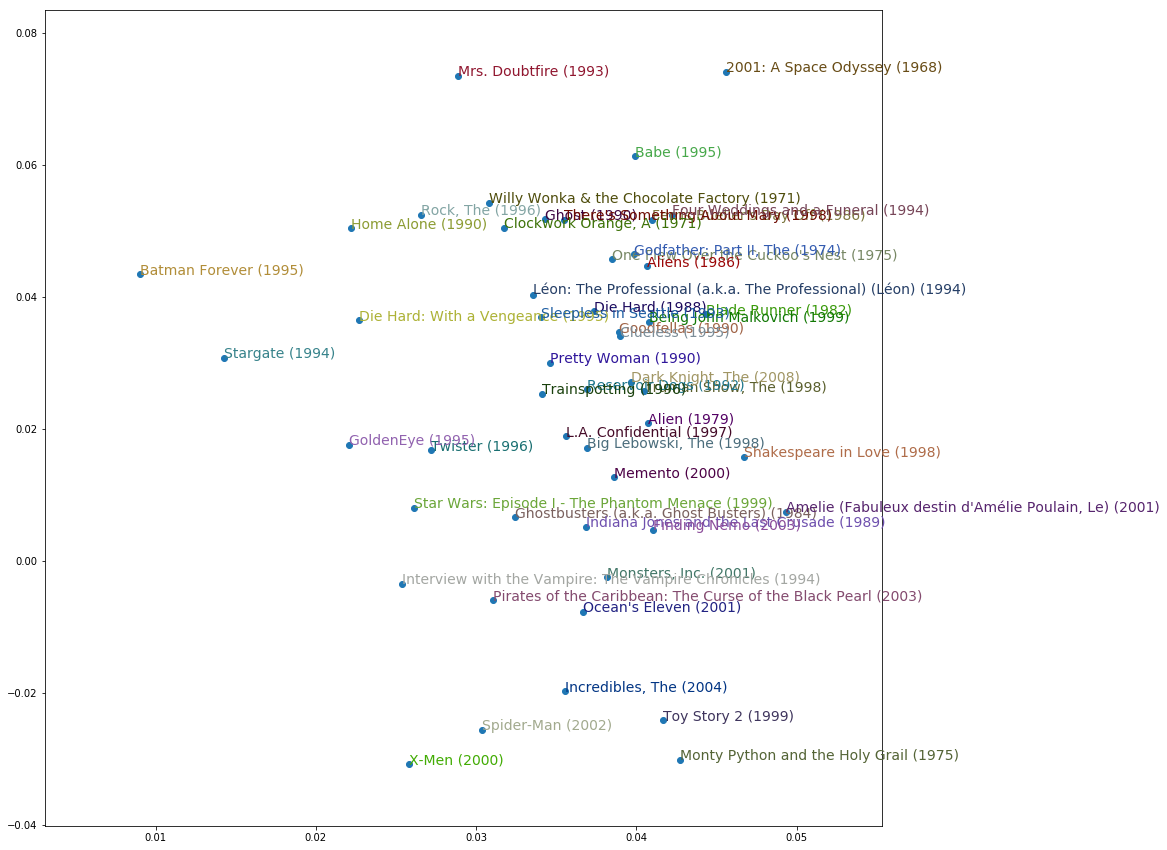

In [63]:
start=50; end=100
X = fac0[start:end]
Y = fac2[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x,y,movie_names[movies[i]], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()

##  Neural net

Rather than creating a special purpose architecture (like our dot-product with bias earlier), it's often both easier and more accurate to use a standard neural network. Let's try it! Here, we simply concatenate the user and movie embeddings into a single vector, which we feed into the neural net.

In [64]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [65]:
x = merge([u, m], mode='concat')
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
nn = Model([user_in, movie_in], x)
nn.compile(Adam(0.001), loss='mse')

In [66]:
nn.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=8, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80084 samples, validate on 19920 samples
Epoch 1/8
80084/80084 [==============================] - 16s - loss: 2.5332 - val_loss: 0.9499
Epoch 2/8
80084/80084 [==============================] - 16s - loss: 1.4464 - val_loss: 0.9067
Epoch 3/8
80084/80084 [==============================] - 15s - loss: 1.2059 - val_loss: 0.8854
Epoch 4/8
80084/80084 [==============================] - 15s - loss: 1.0311 - val_loss: 0.8724
Epoch 5/8
80084/80084 [==============================] - 16s - loss: 0.9136 - val_loss: 0.8603
Epoch 6/8
80084/80084 [==============================] - 15s - loss: 0.8460 - val_loss: 0.8548
Epoch 7/8
80084/80084 [==============================] - 15s - loss: 0.8160 - val_loss: 0.8522
Epoch 8/8
80084/80084 [==============================] - 16s - loss: 0.8060 - val_loss: 0.8522


This improves on our already impressive accuracy even further!